In [1]:
# Importer les bibliothèques
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import cross_val_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42


In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
# importer la base de données de test
db =pd.read_csv('ToutFenetresPlanningVol_10_15min.csv', sep=";" ,encoding = "ISO-8859-1")

db=db.stack().str.replace(',','.').unstack()
db=db.drop(['Date/Heure'],axis=1)
db=db.iloc[1:] # supprimer la ligne des unités
db.iloc[:,:] = db.iloc[:,:].astype(float)

db=db.loc[:,["Température d'air","Vent. externe"]]
#db=db['Vent. externe'].astype(int)


db["Vent. externe"] = db["Vent. externe"].astype(bool)
db["Vent. externe"] = db["Vent. externe"].astype(int)

df_test=db.copy()

In [4]:
# importer la base de données d'entrainement
db_train =pd.read_csv('ToutFenetresPlanningWindowClosed_15min.csv', sep=";" ,encoding = "ISO-8859-1")


db_train=db_train.stack().str.replace(',','.').unstack()
#db_train_Meteo=db_train_Meteo.stack().str.replace(',','.').unstack()
#db_train1=pd.merge(db_train_Meteo,db_train, on='Date/Heure')

db_train1=db_train.drop(['Date/Heure'],axis=1)
db_train_date=db_train['Date/Heure']
db_train1=db_train1.iloc[1:]
db_train1.iloc[:,:] = db_train1.iloc[:,:].astype(float)

df_train=db_train1.loc[:,["Température d'air"]]

In [5]:
df_train

,Température d'air
1,15.85499
2,15.65203
3,15.42231
4,15.19036
5,15.06030
...,...
35036,13.01953
35037,12.94367
35038,12.88518
35039,12.83775


## Auto-Encodeur : Anomalies detection

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [73]:
# Préparation des données et des séquences
feature="Température d'air"

train, test = df_train, df_test

#print(train.shape, test.shape)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[[feature]])

train['var_X'] = scaler.transform(train[[feature]])
test['var_X'] = scaler.transform(test[[feature]])

# fonction de creation des séquences
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


#creation des séquences d'entrainement et test
TIME_STEPS = 3

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['var_X']], train.var_X, TIME_STEPS)
X_test, y_test = create_dataset(test[['var_X']], test.var_X, TIME_STEPS)

print(X_train.shape, "X_train")
print(X_test.shape, "X_test")

(35037, 3, 1) X_train
(35037, 3, 1) X_test


In [74]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns


In [80]:
# création du model auto encodeur avec des cellules LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))
model.add(RepeatVector(X_train.shape[1]))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='Adam', loss='mae')


In [81]:
# Entrainement du model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
    shuffle=False
)

Epoch 1/50
986/986 [==============================] - 8s 5ms/step - loss: 0.1764 - val_loss: 0.0500
Epoch 2/50
986/986 [==============================] - 3s 3ms/step - loss: 0.0678 - val_loss: 0.0319
Epoch 3/50
986/986 [==============================] - 3s 3ms/step - loss: 0.0536 - val_loss: 0.0303
Epoch 4/50
986/986 [==============================] - 3s 3ms/step - loss: 0.0479 - val_loss: 0.0266
Epoch 5/50
986/986 [==============================] - 3s 3ms/step - loss: 0.0479 - val_loss: 0.0238
Epoch 6/50
986/986 [==============================] - 3s 3ms/step - loss: 0.0466 - val_loss: 0.0243
Epoch 7/50
986/986 [==============================] - 3s 3ms/step - loss: 0.0466 - val_loss: 0.0376
Epoch 8/50
986/986 [==============================] - 3s 4ms/step - loss: 0.0463 - val_loss: 0.0335
Epoch 9/50
986/986 [==============================] - 3s 3ms/step - loss: 0.0469 - val_loss: 0.0259
Epoch 10/50
986/986 [==============================] - 3s 3ms/step - loss: 0.0465 - val_loss: 0.0345

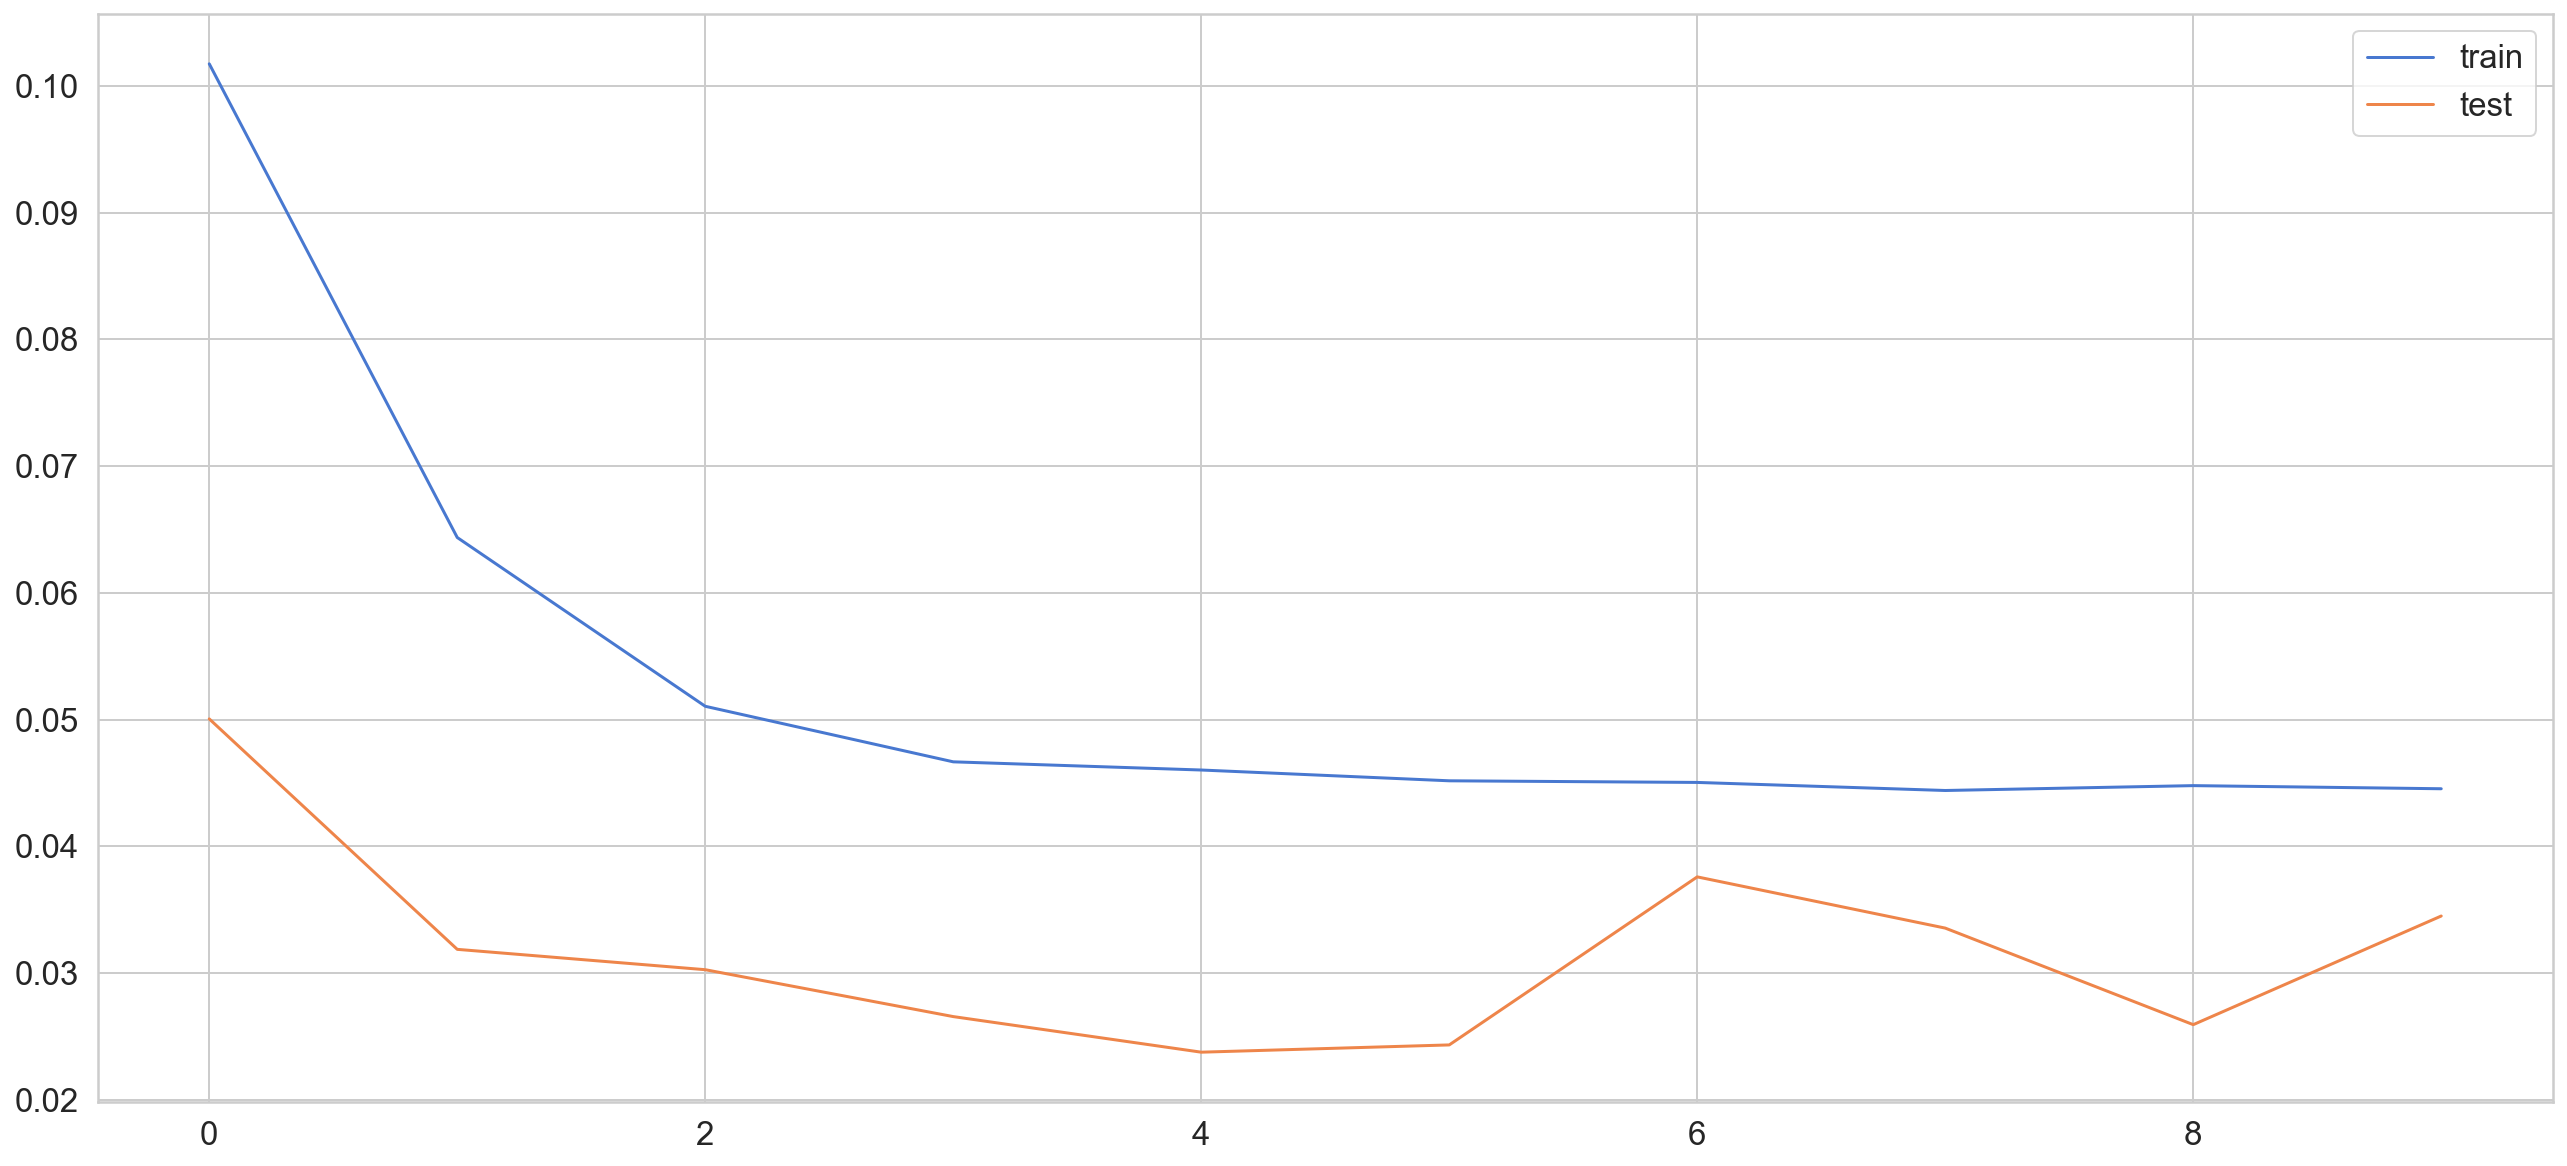

In [82]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

C:\Users\ahmed\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


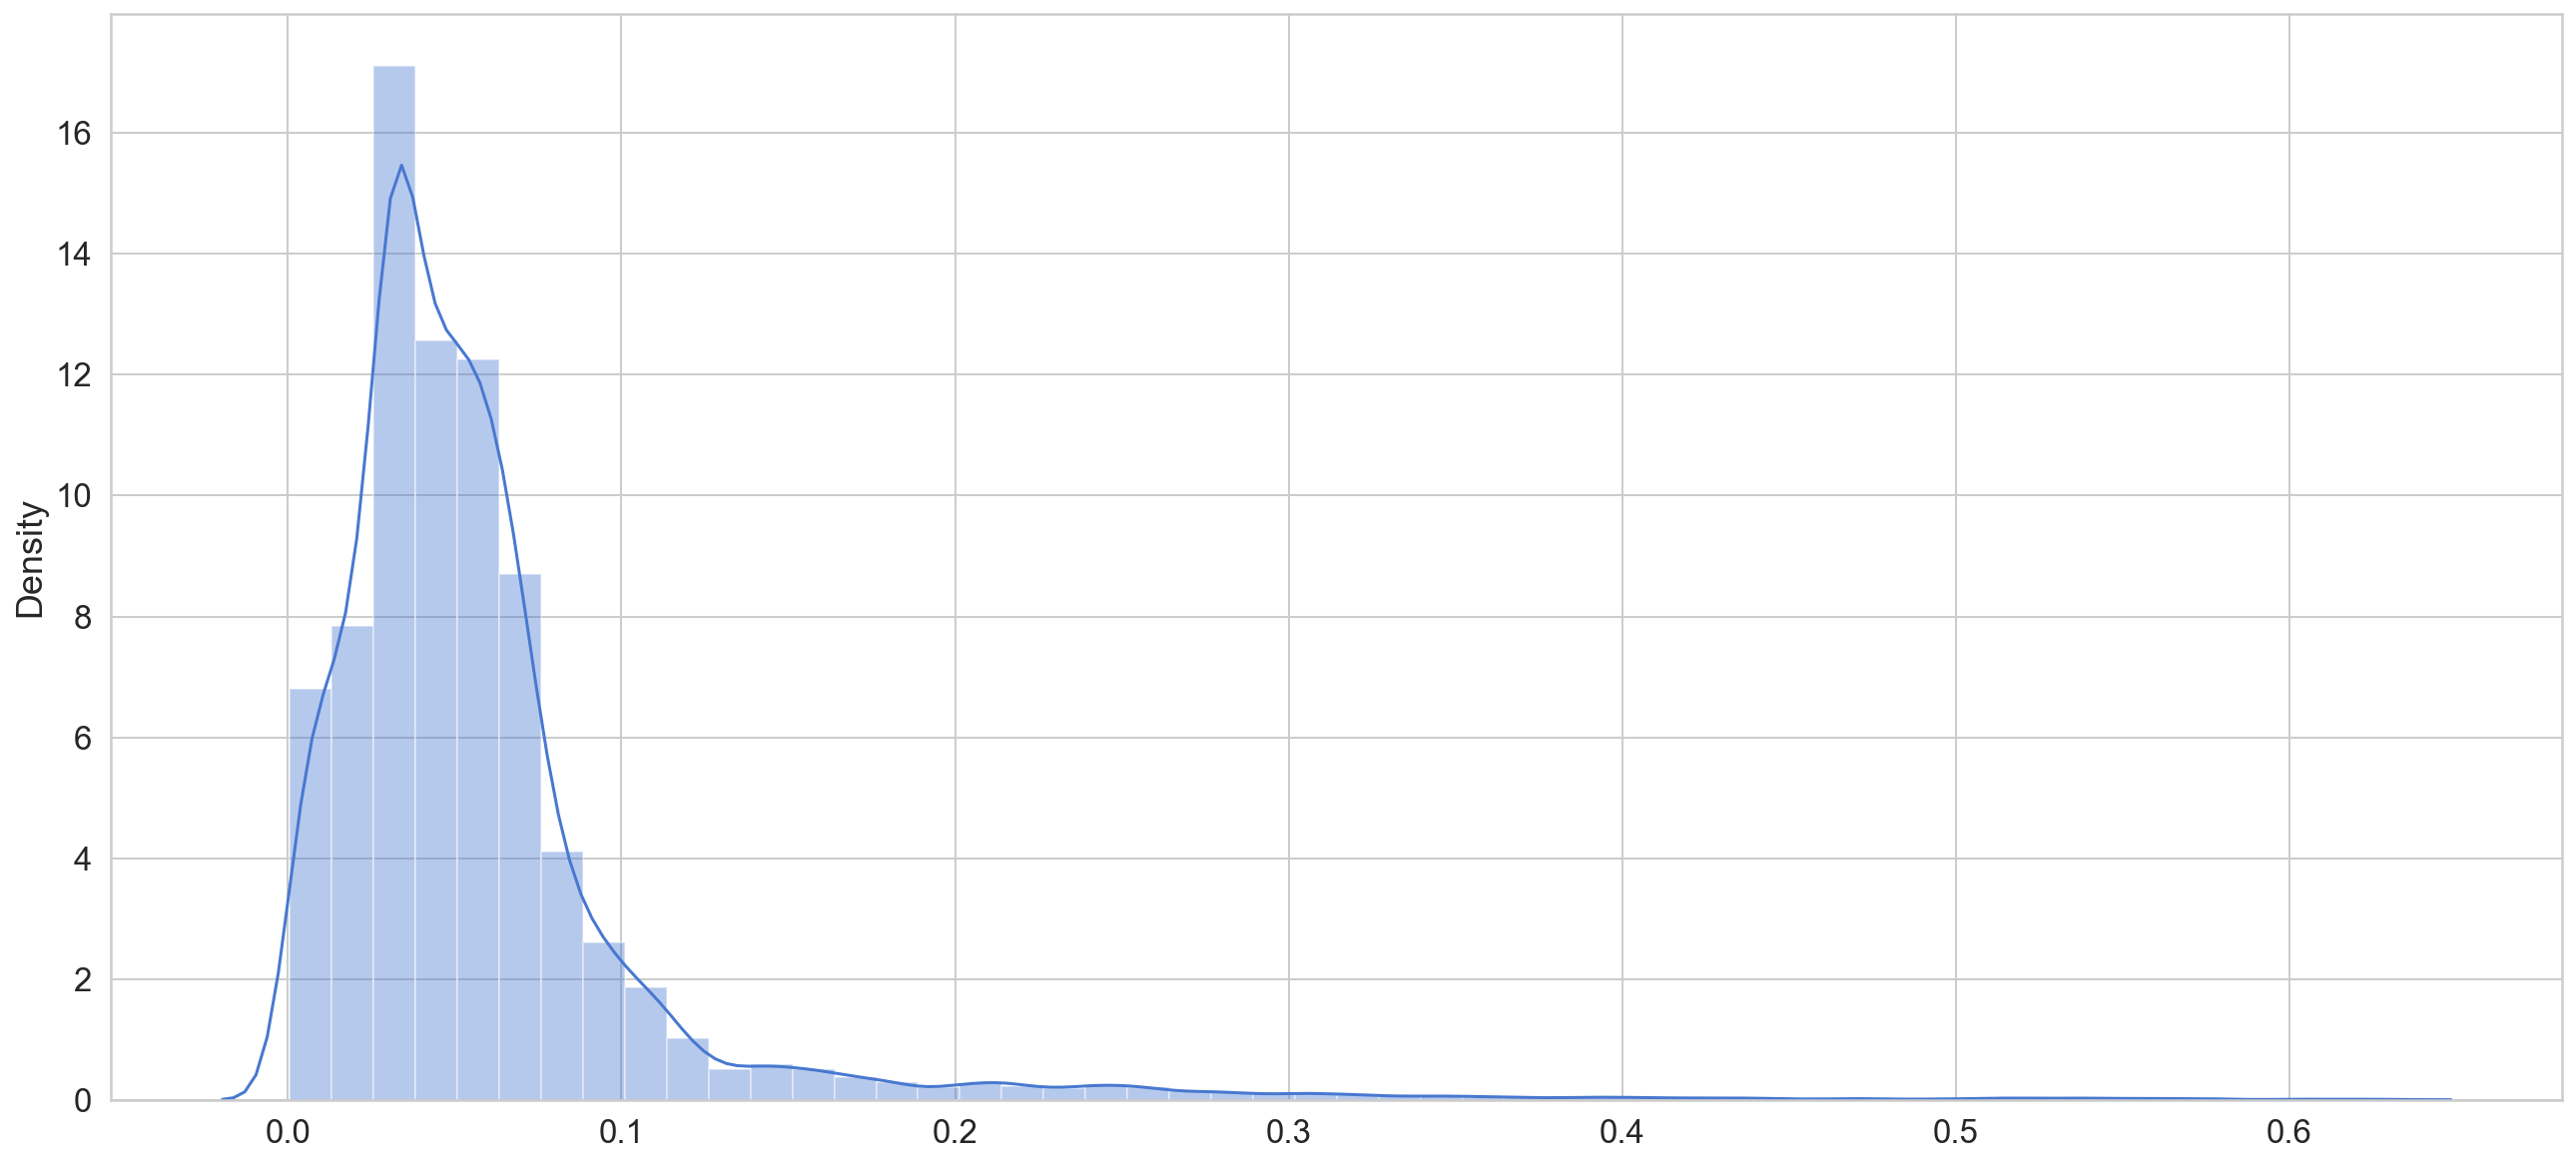

In [83]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

sns.distplot(train_mae_loss, bins=50, kde=True);

In [84]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [85]:
# Determination de Threshold qui maximise le Fscore1 :F1
pd.options.mode.chained_assignment = None # default='warn'
from sklearn.metrics import confusion_matrix
THRESHOLD =0.55
F=[]
Threshold=[]
dbf1=db.copy()
dbf1=dbf1.assign(WindowsPredict=0).copy()
dbf1["WindowsPredict"]=np.zeros(len(dbf1["Vent. externe"]))
dbf2=dbf1.copy()
y_test=dbf2["Vent. externe"]
for i in range(400):
    THRESHOLD =THRESHOLD+0.001

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['var_X'] = test[TIME_STEPS:].var_X

    anomalies = test_score_df[test_score_df.anomaly == True]
    dbf2["WindowsPredict"]=np.zeros(len(dbf2["Vent. externe"]))
    for i in anomalies.index:
        dbf2["WindowsPredict"][i-1]=1;
    
   # confusion_matrix
    y_pred = dbf2["WindowsPredict"]
    cm = confusion_matrix(y_test, y_pred)
    Tp=cm[1,1] # true positive
    Fp=cm[0,1] # false positive
    Fn=cm[1,0] # false negative
             
#  model performance
    Precision=Tp/(Fp+Tp)
    Recall=(Tp/(Tp+Fn))
    F1=(2*Precision*Recall/(Precision+Recall))
    F.append(F1)
    Threshold.append(THRESHOLD)
    #print(THRESHOLD, F1);

Text(0.5, 1.0, 'F_score_max : 0.92')

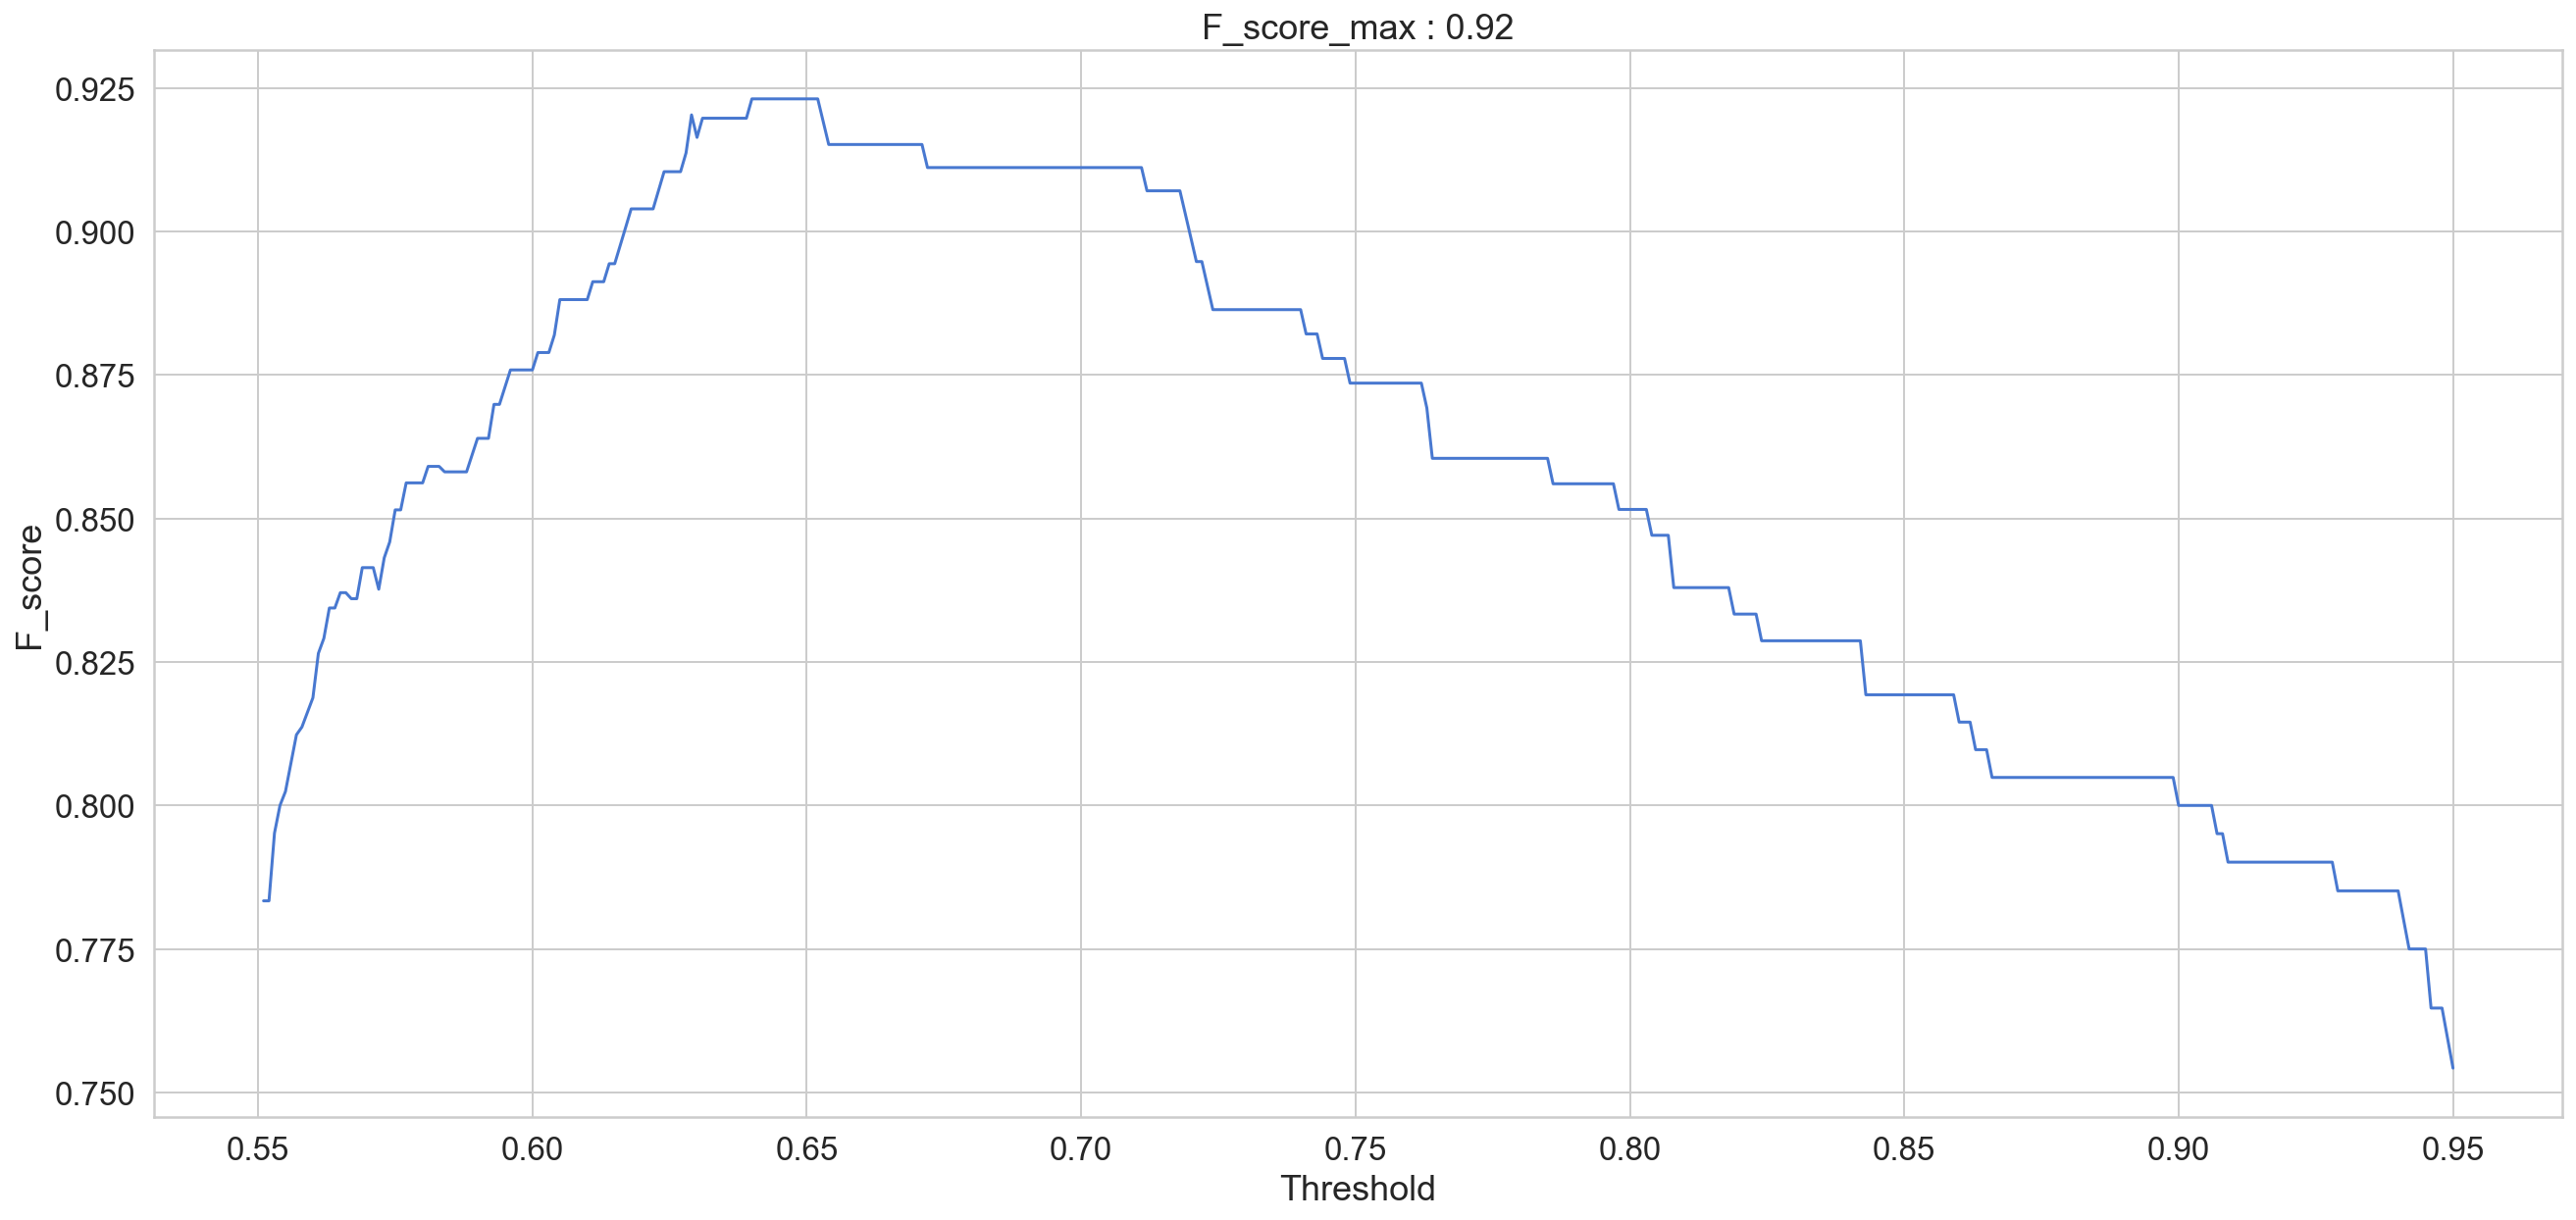

In [86]:
plt.plot(Threshold,F)
plt.xlabel("Threshold")
plt.ylabel("F_score")
plt.title("F_score_max : "+ str(round(max(F),2)))
#plt.legend();

In [56]:
# selection des anomalies
THRESHOLD =Threshold[np.argmax(F)]
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['var_X'] = test[TIME_STEPS:].var_X

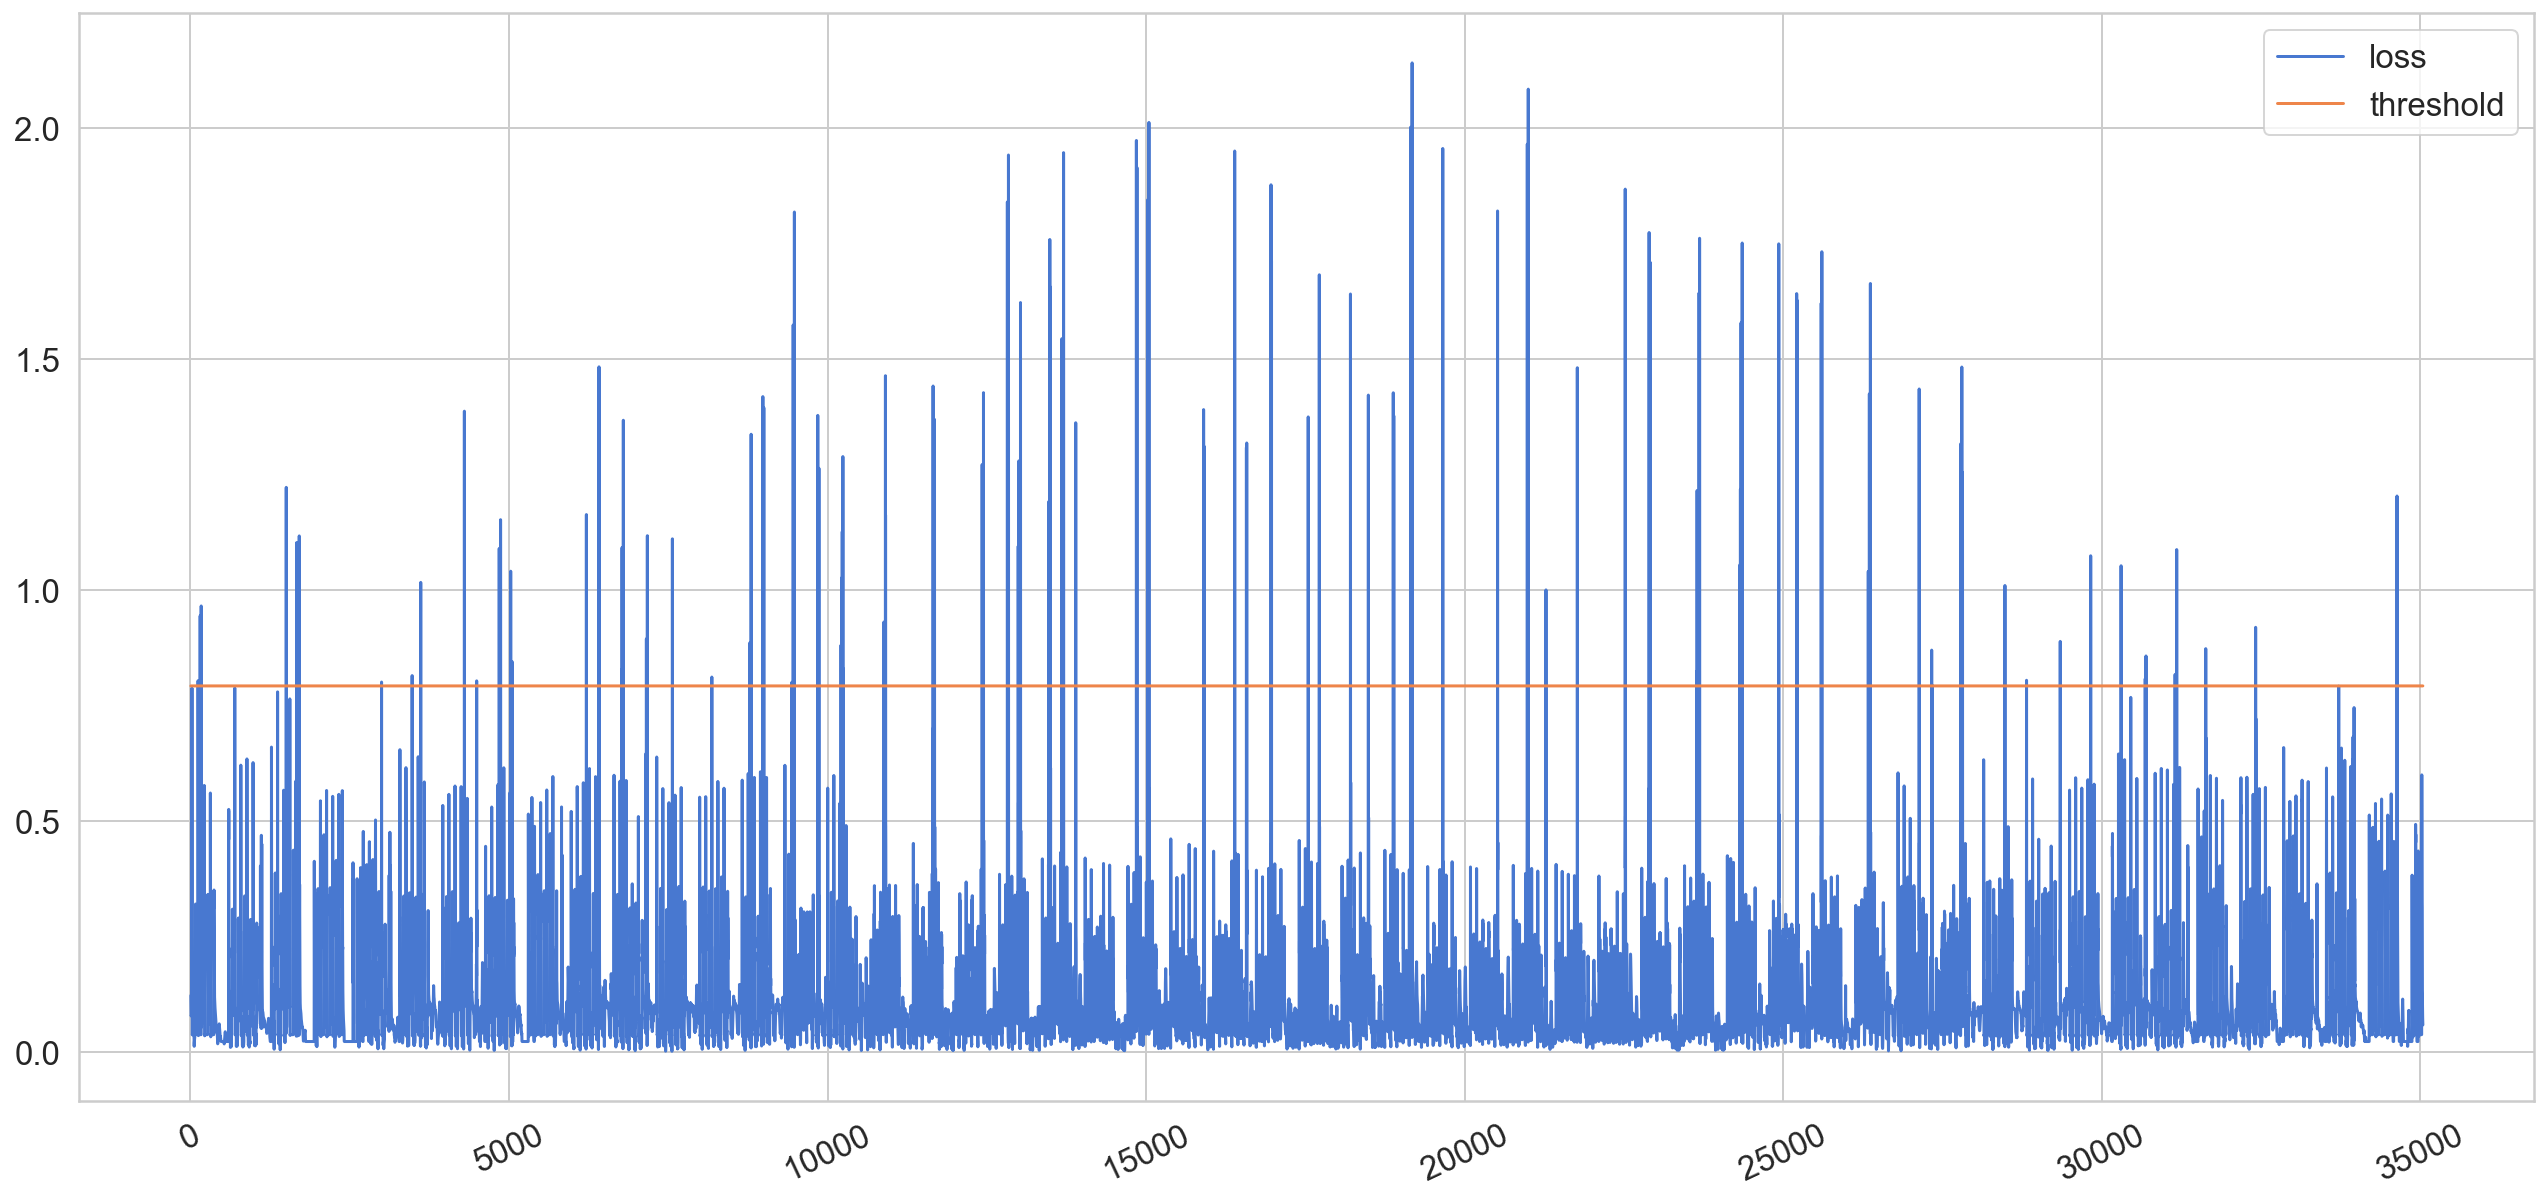

In [57]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [58]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.shape

(127, 4)

C:\Users\ahmed\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


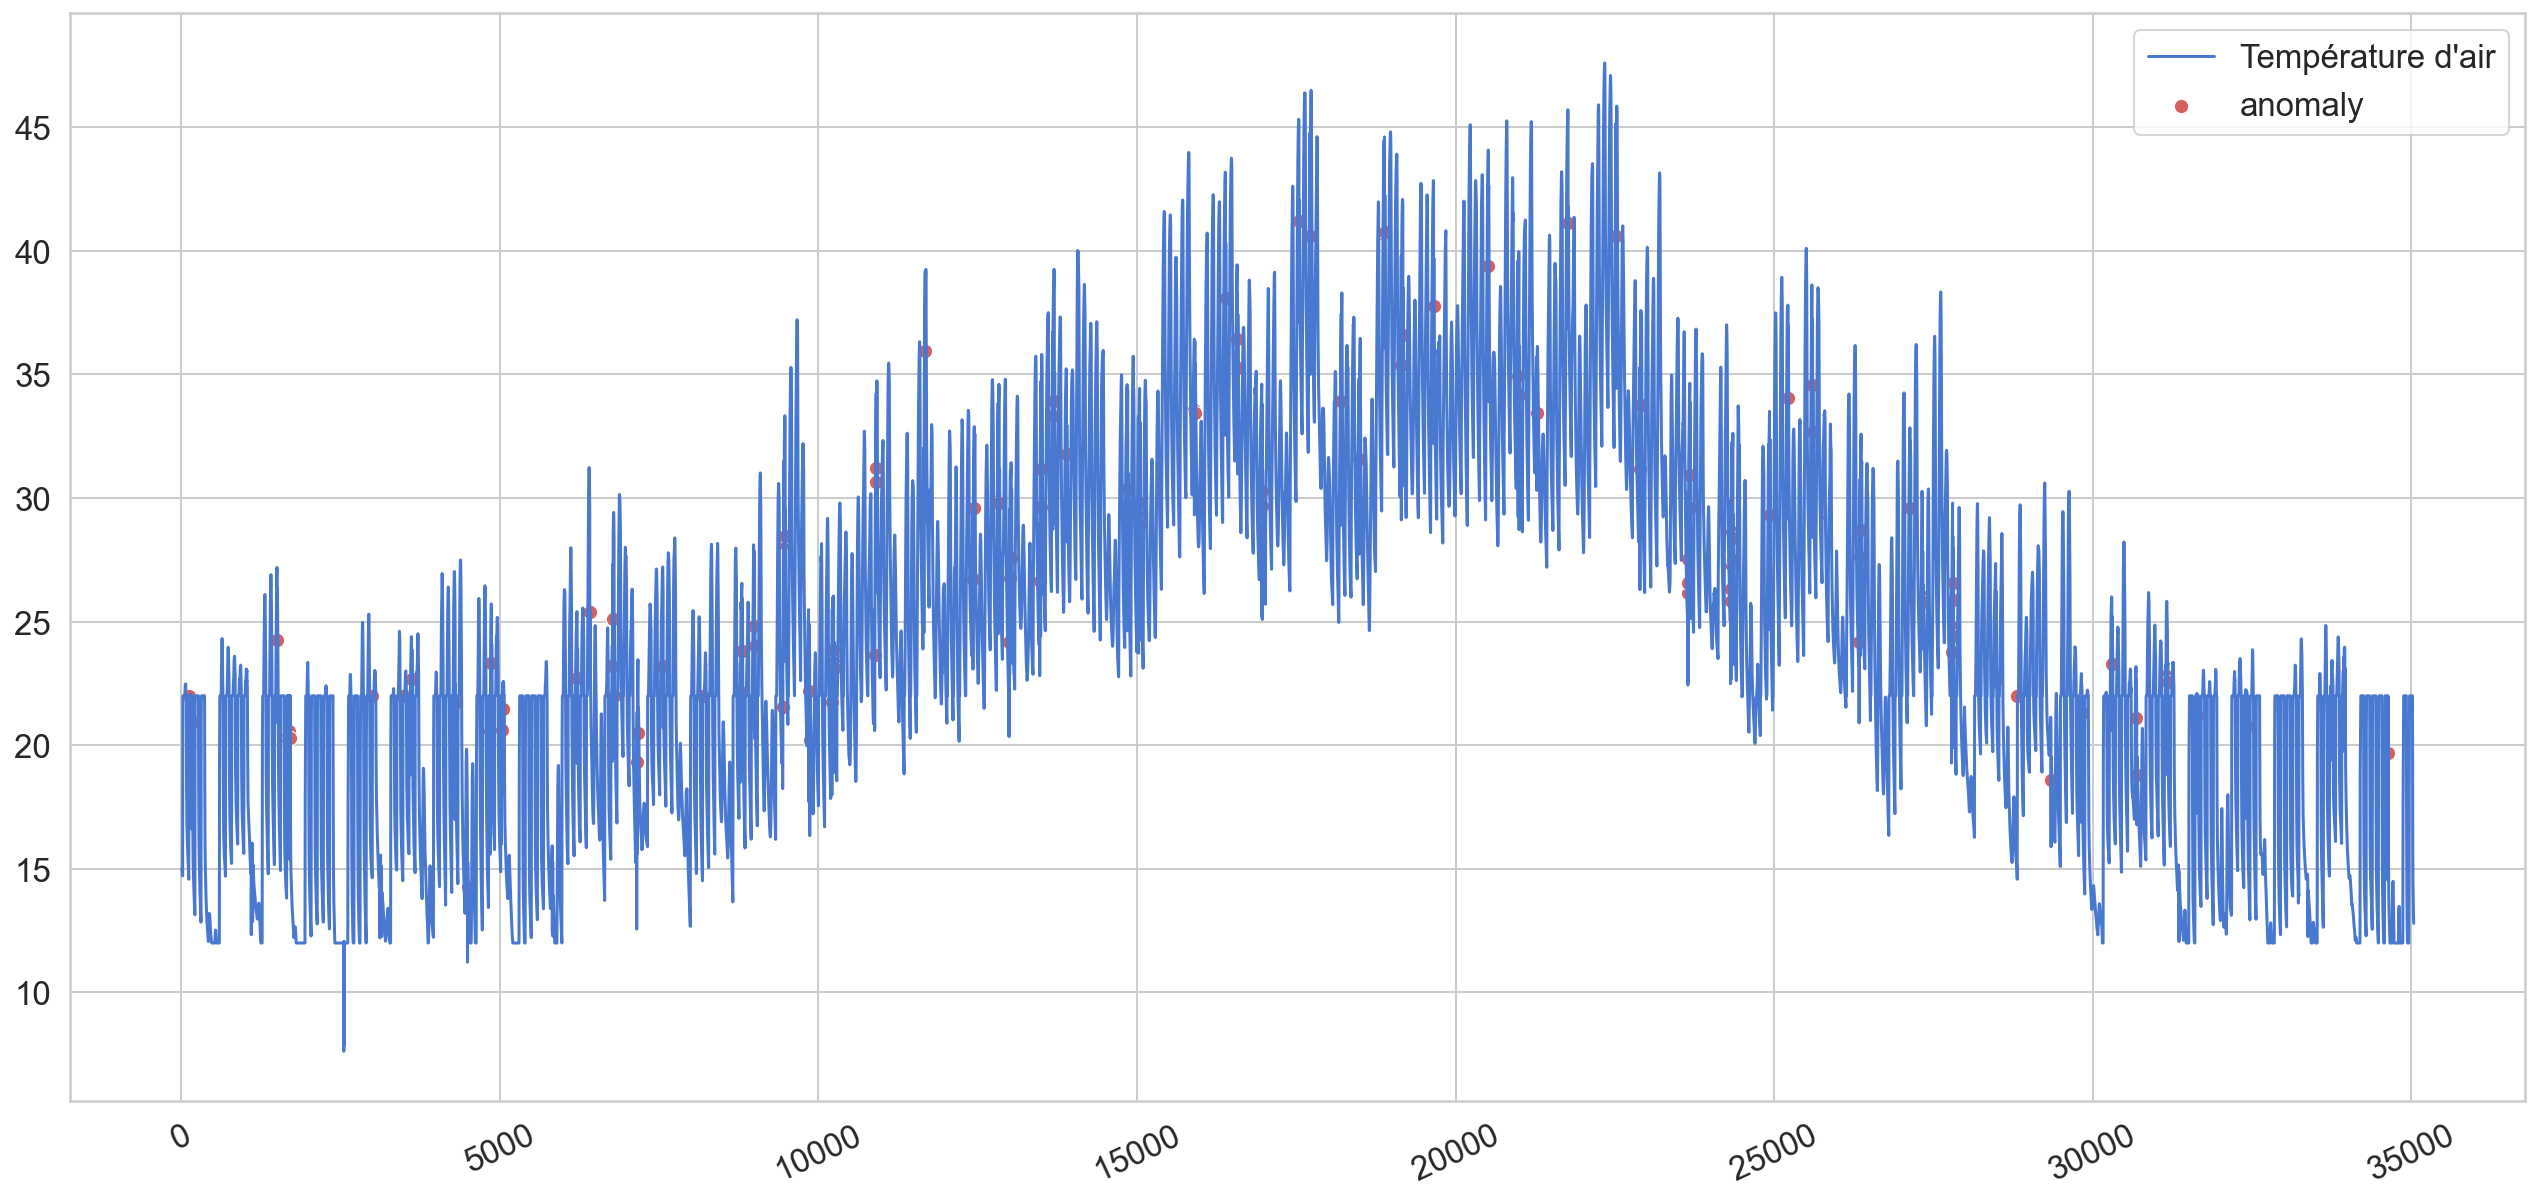

In [59]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].var_X), 
  label= feature
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.var_X),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

In [60]:
dbf=db.copy()

In [61]:
dbf1=dbf.assign(WindowsPredict=0).copy()

In [62]:
for i in anomalies.index:
    dbf1["WindowsPredict"][i-1]=1

In [63]:
# Matrice de confusion pour la detection des anomalies 
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(dbf1["Vent. externe"],dbf1["WindowsPredict"]),
             index = ["WindowsClose_data", "WindowsOpen_data"],
             columns = ["WindowsClose_predict", "WindowsOpen_predict"])

,WindowsClose_predict,WindowsOpen_predict
WindowsClose_data,34888,5
WindowsOpen_data,25,122


In [25]:
THRESHOLD

0.6530000000000001

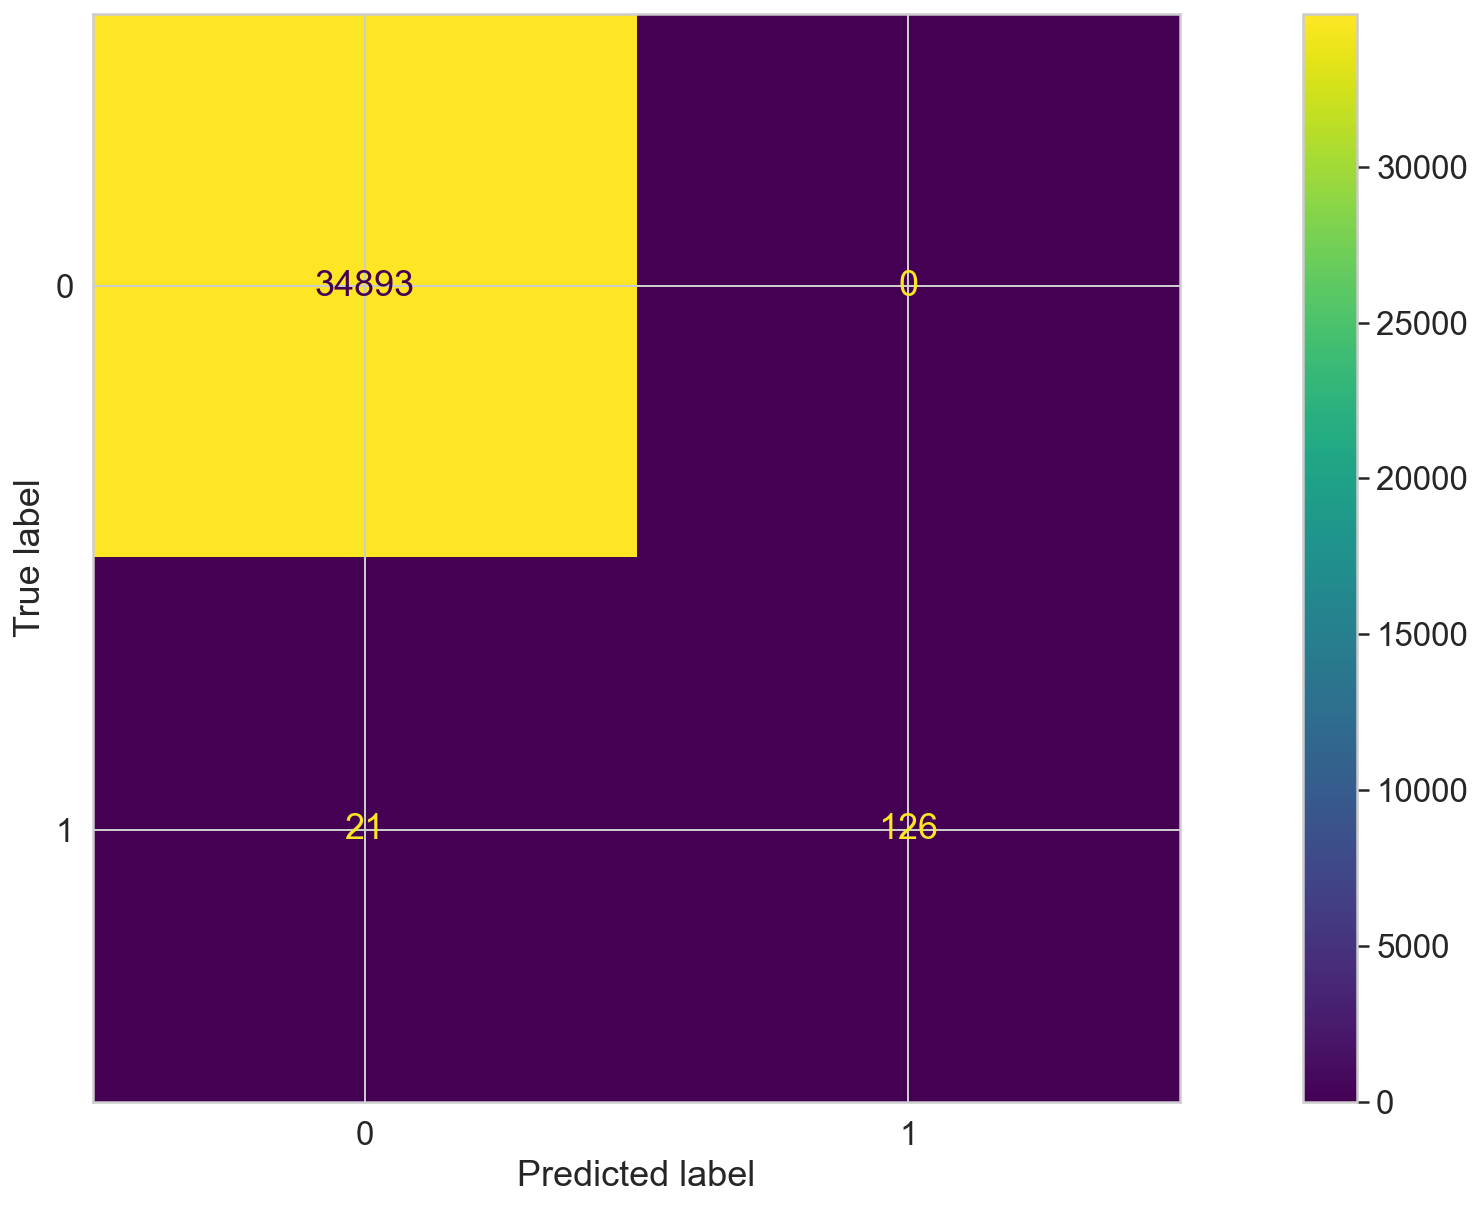

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_test=dbf1["Vent. externe"]
y_pred = dbf1["WindowsPredict"]
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [27]:
anomalies.to_csv('anomalies.csv')

In [161]:
dbf2["Vent. externe"].sum()

147

In [162]:
133+87

220

In [39]:
X_train

array([[[-1.19099709],
        [-1.21693531],
        [-1.24629345]],

       [[-1.21693531],
        [-1.24629345],
        [-1.27593659]],

       [[-1.24629345],
        [-1.27593659],
        [-1.29255822]],

       ...,

       [[-1.54131647],
        [-1.55336798],
        [-1.56306286]],

       [[-1.55336798],
        [-1.56306286],
        [-1.57053787]],

       [[-1.56306286],
        [-1.57053787],
        [-1.57659941]]])